Condition number for A_good: 1.938748901931751
Condition number for A_bad: 28.464868975829507


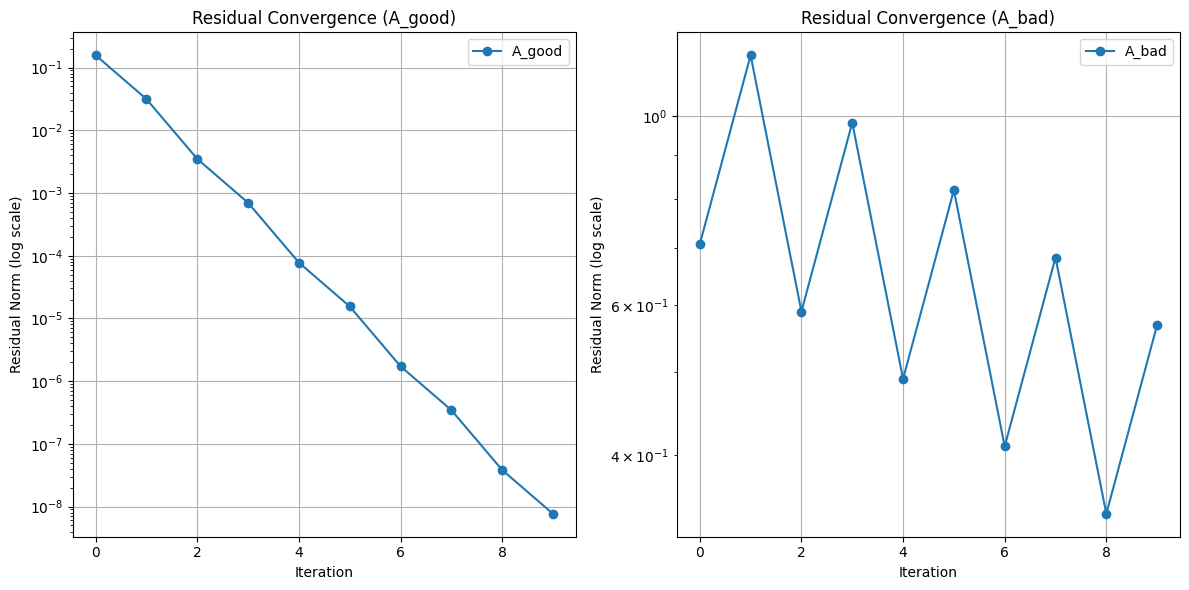

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def krylov_iteration(A, b, max_iter=10):
    x_true = np.linalg.solve(A, b)
    x0 = np.zeros_like(b)
    r_k = b - A @ x0
    x_k = x0.copy()
    residuals = []

    for i in range(1, max_iter + 1):
        Av = A @ r_k
        alpha = np.dot(r_k, r_k) / np.dot(r_k, Av)
        x_k = x_k + alpha * r_k
        r_k = r_k - alpha * Av
        residuals.append(np.linalg.norm(r_k))

    return residuals, x_k, x_true

# Well-conditioned matrix A
A_good = np.array([[4, 1],
                   [1, 3]])
b_good = np.array([1, 1])

# Ill-conditioned matrix A
A_bad = np.array([[10, 2],
                  [3, 1]])
b_bad = np.array([1, 1])

# Krylov iteration for both matrices
residuals_good, x_k_good, x_true_good = krylov_iteration(A_good, b_good)
residuals_bad, x_k_bad, x_true_bad = krylov_iteration(A_bad, b_bad)

# Compute condition numbers
kappa_good = np.linalg.cond(A_good)
kappa_bad = np.linalg.cond(A_bad)
print(f"Condition number for A_good: {kappa_good}")
print(f"Condition number for A_bad: {kappa_bad}")

plt.figure(figsize=(12, 6))

# Good matrix plot
plt.subplot(1, 2, 1)
plt.plot(residuals_good, marker='o', label="A_good")
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Residual Norm (log scale)")
plt.title("Residual Convergence (A_good)")
plt.grid(True)
plt.legend()

# Bad matrix plot
plt.subplot(1, 2, 2)
plt.plot(residuals_bad, marker='o', label="A_bad")
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Residual Norm (log scale)")
plt.title("Residual Convergence (A_bad)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()



<ipython-input-5-c696e99ea216>:25: DeprecationWarning: 'scipy.sparse.linalg.gmres' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  x_no_pre, info_no_pre = gmres(A, b, x0=x0, tol=1e-10, maxiter=2000, callback=callback_no_pre, callback_type='legacy')
<ipython-input-5-c696e99ea216>:39: DeprecationWarning: 'scipy.sparse.linalg.gmres' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  x_jacobi, info_jacobi = gmres(A, b, x0=x0, M=M, tol=1e-10, maxiter=2000, callback=callback_jacobi, callback_type='legacy')


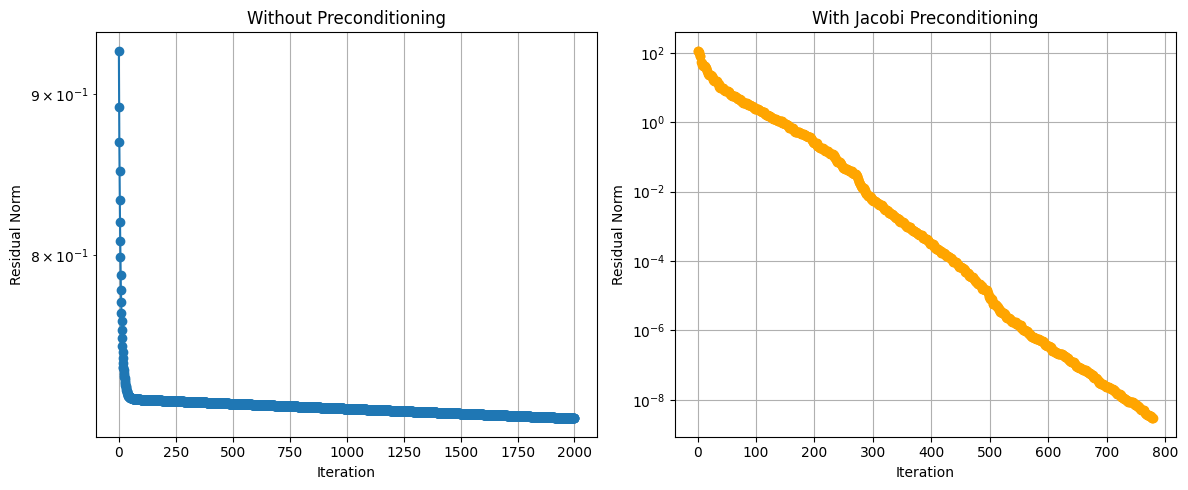

No preconditioning needs None iterations to reach residual < 1e-06
Jacobi preconditioning needs 561 iterations to reach residual < 1e-06


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, diags
from scipy.sparse.linalg import gmres, LinearOperator

np.random.seed(42)
n = 500
large_values = np.logspace(3, 6, n//2)
small_values = np.logspace(-3, 0, n - n//2)
diag_values = np.concatenate([large_values, small_values])
np.random.shuffle(diag_values)
# Creating a sparse A
A = diags(diag_values, 0, shape=(n, n), format='csr')
off_diag_scale = 0.01
upper_off_diag = off_diag_scale * np.random.rand(n-1)
lower_off_diag = off_diag_scale * np.random.rand(n-1)
A = A + diags([upper_off_diag, lower_off_diag], [1, -1])
b = np.random.rand(n)
x0 = np.zeros(n)
# GMRES without preconditioner
residuals_no_pre = []
def callback_no_pre(r):
    residuals_no_pre.append(np.linalg.norm(r))

x_no_pre, info_no_pre = gmres(A, b, x0=x0, tol=1e-10, maxiter=2000, callback=callback_no_pre, callback_type='legacy')

# GMRES with Jacobi preconditioner
D = A.diagonal()
M_inv_diag = 1.0 / D
def jacobi_preconditioner(v):
    return M_inv_diag * v

M = LinearOperator(A.shape, matvec=jacobi_preconditioner)

residuals_jacobi = []
def callback_jacobi(r):
    residuals_jacobi.append(np.linalg.norm(r))

x_jacobi, info_jacobi = gmres(A, b, x0=x0, M=M, tol=1e-10, maxiter=2000, callback=callback_jacobi, callback_type='legacy')

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(residuals_no_pre, marker='o')
plt.title("Without Preconditioning")
plt.xlabel("Iteration")
plt.ylabel("Residual Norm")
plt.yscale('log')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(residuals_jacobi, marker='o', color='orange')
plt.title("With Jacobi Preconditioning")
plt.xlabel("Iteration")
plt.ylabel("Residual Norm")
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()

target = 1e-6
def first_below(res_list, target):
    for i, r in enumerate(res_list):
        if r < target:
            return i
    return None

idx_no_pre = first_below(residuals_no_pre, target)
idx_jacobi = first_below(residuals_jacobi, target)

print("No preconditioning needs {} iterations to reach residual < {}".
      format(idx_no_pre, target))
print("Jacobi preconditioning needs {} iterations to reach residual < {}".
      format(idx_jacobi, target))

